In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Rio De Janeiro - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_RJ.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Rio de-01eiro - value,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Rio De Janeiro - Consumo de Cimento (t),Rio De Janeiro - Produção de Cimento (t),Rio de Janeiro - IDH,Rio de Janeiro - PIB - Estadual,Rio de Janeiro - PIB - Construção Civil,Rio de Janeiro - PIB - Per Capita,Rio de Janeiro - PIB Preços de Mercado,Rio de Janeiro - Desemprego
0,2003-1,0.291137,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,254.362,199.081280,0.773489,3.583430e+08,1.813534e+07,22.143720,3.472846e+08,8.356512
1,2003-2,0.293538,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,252.842,198.561780,0.773547,3.587441e+08,1.814108e+07,22.149228,3.474056e+08,8.350332
2,2003-3,0.295914,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,229.385,198.773336,0.773606,3.591452e+08,1.814681e+07,22.154735,3.475266e+08,8.344152
3,2003-4,0.298264,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,243.407,198.753800,0.773665,3.595464e+08,1.815255e+07,22.160243,3.476476e+08,8.337971
4,2003-5,0.300588,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,256.535,198.721455,0.773724,3.599475e+08,1.815828e+07,22.165750,3.477686e+08,8.331791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,0.559828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,241.702,232.917513,NaN,NaN,NaN,NaN,NaN,NaN
236,2022-9,0.558289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,221.036,232.658000,NaN,NaN,NaN,NaN,NaN,NaN
237,2022-10,0.556367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,224.399,232.339116,NaN,NaN,NaN,NaN,NaN,NaN
238,2022-11,0.554021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,221.319,231.667333,NaN,NaN,NaN,NaN,NaN,NaN


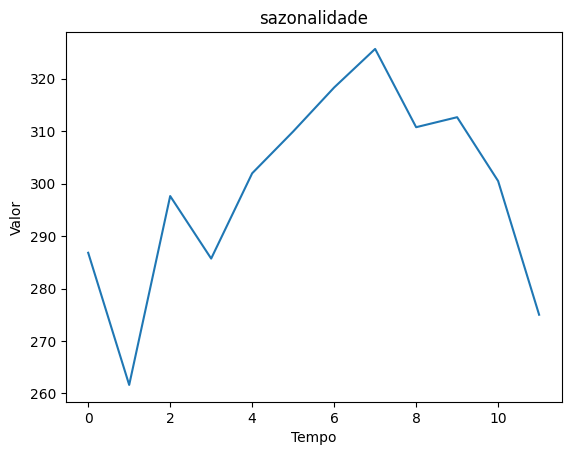

,sazonalidade
sazonalidade,
0,286.811100
1,261.630600
2,297.615075
3,285.702100
4,301.953300
5,309.914400
6,318.299950
7,325.649400
8,310.734600


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Rio de-01eiro - value,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Rio De Janeiro - Produção de Cimento (t),Rio de Janeiro - IDH,Rio de Janeiro - PIB - Estadual,Rio de Janeiro - PIB - Construção Civil,Rio de Janeiro - PIB - Per Capita,Rio de Janeiro - PIB Preços de Mercado,Rio de Janeiro - Desemprego,sazonalidade,Rio De Janeiro - Consumo de Cimento (t)
0,2003-1,0.291137,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,199.081280,0.773489,3.583430e+08,1.813534e+07,22.143720,3.472846e+08,8.356512,286.811100,254.362
1,2003-2,0.293538,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,198.561780,0.773547,3.587441e+08,1.814108e+07,22.149228,3.474056e+08,8.350332,261.630600,252.842
2,2003-3,0.295914,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,198.773336,0.773606,3.591452e+08,1.814681e+07,22.154735,3.475266e+08,8.344152,297.615075,229.385
3,2003-4,0.298264,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,198.753800,0.773665,3.595464e+08,1.815255e+07,22.160243,3.476476e+08,8.337971,285.702100,243.407
4,2003-5,0.300588,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,198.721455,0.773724,3.599475e+08,1.815828e+07,22.165750,3.477686e+08,8.331791,301.953300,256.535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,0.559828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,232.917513,NaN,NaN,NaN,NaN,NaN,NaN,325.649400,241.702
236,2022-9,0.558289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,232.658000,NaN,NaN,NaN,NaN,NaN,NaN,310.734600,221.036
237,2022-10,0.556367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,232.339116,NaN,NaN,NaN,NaN,NaN,NaN,312.638850,224.399
238,2022-11,0.554021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,231.667333,NaN,NaN,NaN,NaN,NaN,NaN,300.478750,221.319


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      246.602
1      237.093
2      270.163
3      263.941
4      273.825
        ...   
235        NaN
236        NaN
237        NaN
238        NaN
239        NaN
Name: Rio De Janeiro - Consumo de Cimento (t), Length: 240, dtype: float64

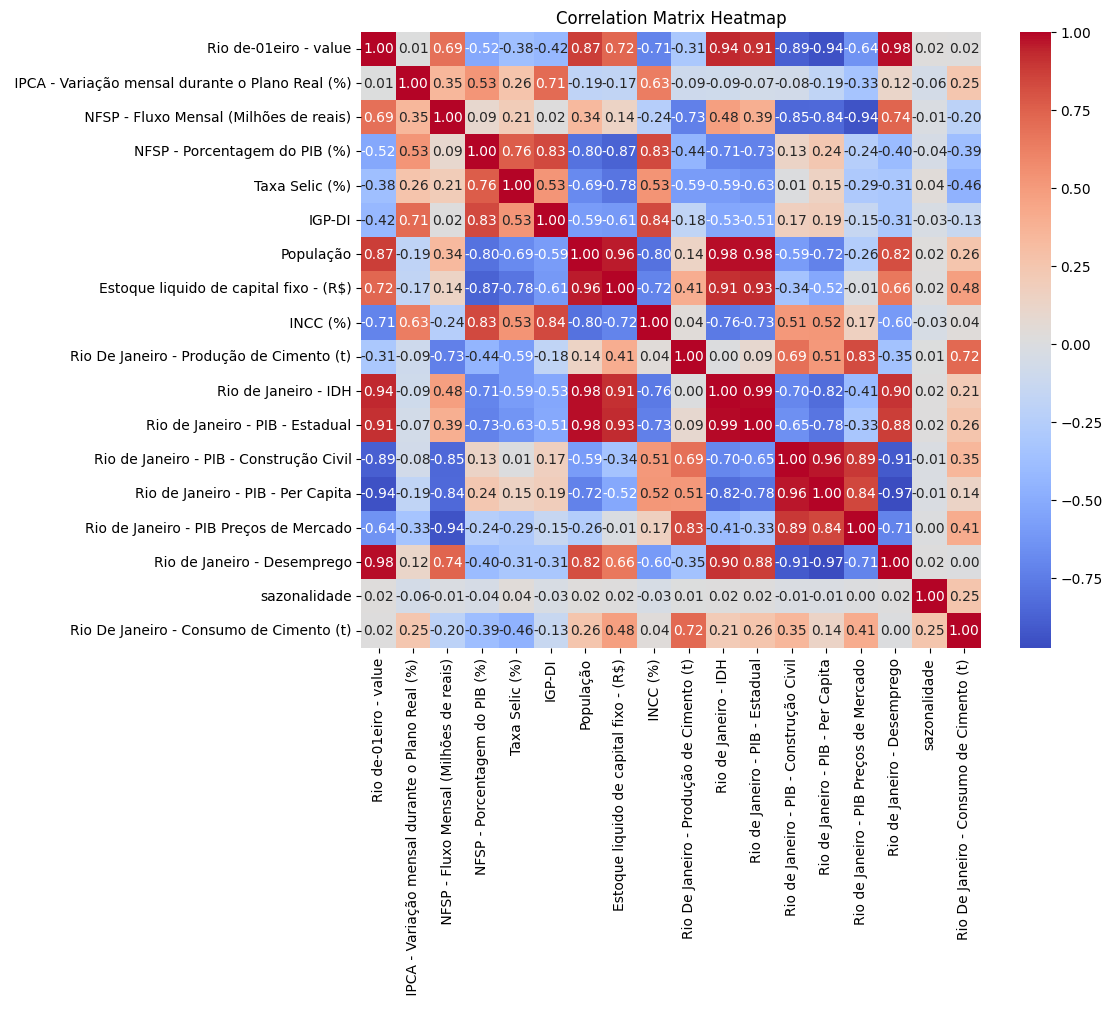

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Rio de-01eiro - value,1.179293e+05
1,IPCA - Variação mensal durante o Plano Real (%),2.591708e+03
2,NFSP - Fluxo Mensal (Milhões de reais),3.577187e+02
3,NFSP - Porcentagem do PIB (%),7.268648e+02
4,Taxa Selic (%),5.660044e+01
5,IGP-DI,4.415618e+02
6,População,1.146264e+07
7,Estoque liquido de capital fixo - (R$),7.498889e+06
8,INCC (%),1.346759e+03
9,Rio De Janeiro - Produção de Cimento (t),1.802925e+04


In [39]:
data = remove_high_vif_columns(safe_data, 10000000)
data

Num columns removed: 2


,Rio de-01eiro - value,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Rio De Janeiro - Produção de Cimento (t),Rio de Janeiro - PIB - Estadual,Rio de Janeiro - PIB - Construção Civil,Rio de Janeiro - PIB - Per Capita,Rio de Janeiro - Desemprego,sazonalidade
0,0.291137,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,199.081280,3.583430e+08,1.813534e+07,22.143720,8.356512,286.811100
1,0.293538,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,198.561780,3.587441e+08,1.814108e+07,22.149228,8.350332,261.630600
2,0.295914,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,198.773336,3.591452e+08,1.814681e+07,22.154735,8.344152,297.615075
3,0.298264,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,198.753800,3.595464e+08,1.815255e+07,22.160243,8.337971,285.702100
4,0.300588,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,198.721455,3.599475e+08,1.815828e+07,22.165750,8.331791,301.953300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.440386,0.366904,-5783.316460,2.206994,0.545067,0.471521,1.987710e+08,7.783063e+06,0.378150,200.661356,4.120500e+08,1.730116e+07,21.873489,12.640247,325.649400
176,0.441421,0.358935,-6001.730740,2.215328,0.782910,0.476827,1.988450e+08,7.780841e+06,0.377666,201.758628,4.120803e+08,1.730238e+07,21.876366,12.627623,310.734600
177,0.442063,0.354313,-6454.887704,2.232466,0.909682,0.475427,1.989190e+08,7.778619e+06,0.377838,203.004428,4.121106e+08,1.730360e+07,21.879243,12.614999,312.638850
178,0.442308,0.352728,-6243.191421,2.263185,1.050614,0.491301,1.989930e+08,7.776397e+06,0.370057,204.563046,4.121409e+08,1.730481e+07,21.882120,12.602375,300.478750


In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Rio De Janeiro - Produção de Cimento (t),Rio de Janeiro - PIB - Estadual,Rio de Janeiro - PIB - Construção Civil,Rio de Janeiro - PIB - Per Capita,Rio de Janeiro - Desemprego
0,2.802383,0.604311,4.268118,2.039314,3.921218,-2.016914,-2.299937,3.214079,-1.075959,-1.736304,0.028239,0.034039,-0.723972
1,2.402642,0.609431,4.096014,1.195209,3.582946,-1.988421,-2.263992,3.051841,-1.093934,-1.713787,0.041861,0.065861,-0.727178
2,2.158351,0.562720,3.903698,2.960381,3.422548,-1.959928,-2.228047,2.944772,-1.086614,-1.691271,0.055484,0.097683,-0.730385
3,2.049492,0.455907,3.693727,1.040752,3.167136,-1.931435,-2.192102,2.842174,-1.087290,-1.668755,0.069107,0.129506,-0.733591
4,1.905441,0.498418,3.454992,2.351150,2.986591,-1.902941,-2.156157,3.059587,-1.088409,-1.646238,0.082729,0.161328,-0.736797
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,-1.429358,0.425789,-0.584804,-1.503380,-0.514871,1.368581,0.605679,-1.872446,-1.021286,1.278435,-1.953470,-1.527378,1.498411
176,-1.523783,0.339575,-0.580461,-0.733634,-0.473208,1.380202,0.591420,-1.876611,-0.983319,1.280134,-1.950582,-1.510755,1.491862
177,-1.578548,0.160702,-0.571531,-0.323353,-0.484199,1.391823,0.577161,-1.875135,-0.940213,1.281834,-1.947695,-1.494133,1.485312
178,-1.597335,0.244264,-0.555524,0.132757,-0.359568,1.403443,0.562902,-1.942040,-0.886283,1.283534,-1.944807,-1.477510,1.478763


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Rio De Janeiro - Produção de Cimento (t),Rio de Janeiro - PIB - Estadual,Rio de Janeiro - PIB - Construção Civil,Rio de Janeiro - PIB - Per Capita,Rio de Janeiro - Desemprego
0,2.802383,0.604311,4.268118,2.039314,3.921218,-2.016914,-2.299937,3.214079,-1.075959,-1.736304,0.028239,0.034039,-0.723972
1,2.402642,0.609431,4.096014,1.195209,3.582946,-1.988421,-2.263992,3.051841,-1.093934,-1.713787,0.041861,0.065861,-0.727178
2,2.158351,0.562720,3.903698,2.960381,3.422548,-1.959928,-2.228047,2.944772,-1.086614,-1.691271,0.055484,0.097683,-0.730385
3,2.049492,0.455907,3.693727,1.040752,3.167136,-1.931435,-2.192102,2.842174,-1.087290,-1.668755,0.069107,0.129506,-0.733591
4,1.905441,0.498418,3.454992,2.351150,2.986591,-1.902941,-2.156157,3.059587,-1.088409,-1.646238,0.082729,0.161328,-0.736797
...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,-0.960452,1.465326,-0.676734,0.472779,-1.087000,1.228701,0.759879,-1.491033,-1.578000,1.230749,-1.859723,-1.715332,1.573898
164,-1.007966,1.351131,-0.668750,0.302784,-0.904679,1.240408,0.749001,-1.525186,-1.567412,1.237906,-1.882515,-1.701013,1.567970
165,-0.976556,1.143146,-0.657609,0.339539,-0.900134,1.252114,0.738124,-1.546744,-1.546446,1.245064,-1.905307,-1.686694,1.562041
166,-1.146834,1.542609,-0.647588,0.472795,-1.136836,1.263821,0.727246,-1.586381,-1.540677,1.252222,-1.928098,-1.672375,1.556113


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      246.602
1      237.093
2      270.163
3      263.941
4      273.825
        ...   
163    229.696
164    232.624
165    234.262
166    217.727
167    190.769
Name: Rio De Janeiro - Consumo de Cimento (t), Length: 168, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 13)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Rio De Janeiro - Produção de Cimento (t),Rio de Janeiro - PIB - Estadual,Rio de Janeiro - PIB - Construção Civil,Rio de Janeiro - PIB - Per Capita,Rio de Janeiro - Desemprego
132,1.530065,0.817451,-0.366715,-0.530011,0.174628,0.848407,0.965586,-0.066954,0.526952,1.030909,-0.499971,-0.821387,1.062719
133,1.649361,1.130195,-0.350285,-0.532694,0.240832,0.861179,0.962419,-0.130652,0.472088,1.036501,-0.561922,-0.882088,1.091726
134,1.622916,1.160498,-0.335122,-0.186421,0.176857,0.873950,0.959252,-0.079602,0.393945,1.042092,-0.623872,-0.942788,1.120733
135,1.581460,1.131990,-0.321950,-0.719664,-0.005233,0.886722,0.956085,-0.034473,0.313726,1.047684,-0.685822,-1.003488,1.149740
136,1.638292,1.384387,-0.302995,-0.798520,0.097576,0.899493,0.952918,-0.177535,0.232099,1.053276,-0.747773,-1.064189,1.178747
137,1.643773,1.375487,-0.290554,-0.612129,0.431487,0.912265,0.949751,-0.208868,0.148612,1.058868,-0.809723,-1.124889,1.207753
138,1.704584,1.438928,-0.281926,-0.476740,0.482414,0.925036,0.946584,-0.245300,0.063609,1.064460,-0.871673,-1.185590,1.236760
139,1.841703,1.569590,-0.275931,-0.211736,0.657043,0.937808,0.943417,-0.333490,-0.023004,1.070052,-0.933624,-1.246290,1.265767
140,1.837218,1.584058,-0.271466,-0.484608,0.678386,0.950580,0.940250,-0.296846,-0.110768,1.075644,-0.995574,-1.306990,1.294774
141,1.797860,1.166380,-0.273241,-0.183907,0.727143,0.963351,0.937082,-0.292462,-0.199731,1.081235,-1.057525,-1.367691,1.323780


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 13)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(144, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[1432155567, 3480750115, 131552221, 4055924320, 1382293123, 2096144360, 1231541886, 1549786974, 1828352811, 2564023379]


Step: 0 ___________________________________________
val_loss: 1811.213623046875
winner_seed: 1432155567


Step: 1 ___________________________________________
val_loss: 470.92388916015625
winner_seed: 3480750115


Step: 2 ___________________________________________
val_loss: 2991.932861328125


Step: 3 ___________________________________________
val_loss: 1091.7398681640625


Step: 4 ___________________________________________
val_loss: 4322.625


Step: 5 ___________________________________________
val_loss: 22902969729024.0


Step: 6 ___________________________________________
val_loss: 1522.8284912109375


Step: 7 ___________________________________________
val_loss: 1540.486572265625


Step: 8 ___________________________________________
val_loss: 1481.6014404296875


Step: 9 ___________________________________________
val_loss: 1937.0185546875


final_seed: 348075

In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 2s 114ms/step - loss: 76857.8047 - val_loss: 25943.3027
Epoch 2/10000
4/4 [==============================] - 0s 7ms/step - loss: 5737.3115 - val_loss: 18858.7188
Epoch 3/10000
4/4 [==============================] - 0s 7ms/step - loss: 5839.5708 - val_loss: 21128.0918
Epoch 4/10000
4/4 [==============================] - 0s 7ms/step - loss: 5437.0024 - val_loss: 16036.5283
Epoch 5/10000
4/4 [==============================] - 0s 7ms/step - loss: 5431.9038 - val_loss: 16152.4902
Epoch 6/10000
4/4 [==============================] - 0s 7ms/step - loss: 5359.4478 - val_loss: 18352.0195
Epoch 7/10000
4/4 [==============================] - 0s 7ms/step - loss: 4928.2861 - val_loss: 10072.2100
Epoch 8/10000
4/4 [==============================] - 0s 7ms/step - loss: 3785.3882 - val_loss: 7644.8110
Epoch 9/10000
4/4 [==============================] - 0s 7ms/step - loss: 2483.3350 - val_loss: 1580.8046
Epoch 10/10000
4/4 [=========================

4/4 [==============================] - 0s 7ms/step - loss: 844.2461 - val_loss: 4024.4785
Epoch 79/10000
4/4 [==============================] - 0s 7ms/step - loss: 911.5193 - val_loss: 4544.5752
Epoch 80/10000
4/4 [==============================] - 0s 7ms/step - loss: 1089.8687 - val_loss: 4267.2080
Epoch 81/10000
4/4 [==============================] - 0s 7ms/step - loss: 787.1555 - val_loss: 4292.9995
Epoch 82/10000
4/4 [==============================] - 0s 7ms/step - loss: 1075.0834 - val_loss: 3975.2891
Epoch 83/10000
4/4 [==============================] - 0s 7ms/step - loss: 898.2682 - val_loss: 4262.3628
Epoch 84/10000
4/4 [==============================] - 0s 7ms/step - loss: 838.6555 - val_loss: 4295.9839
Epoch 85/10000
4/4 [==============================] - 0s 7ms/step - loss: 720.3354 - val_loss: 4074.5359
Epoch 86/10000
4/4 [==============================] - 0s 7ms/step - loss: 738.4240 - val_loss: 4116.8018
Epoch 87/10000
4/4 [==============================] - 0s 7ms/step - 

4/4 [==============================] - 0s 7ms/step - loss: 627.8138 - val_loss: 8103.4326
Epoch 156/10000
4/4 [==============================] - 0s 7ms/step - loss: 660.1525 - val_loss: 7957.6367
Epoch 157/10000
4/4 [==============================] - 0s 7ms/step - loss: 822.7781 - val_loss: 8137.5874
Epoch 158/10000
4/4 [==============================] - 0s 7ms/step - loss: 672.3005 - val_loss: 7766.0171
Epoch 159/10000
4/4 [==============================] - 0s 7ms/step - loss: 695.8883 - val_loss: 8027.4985
Epoch 160/10000
4/4 [==============================] - 0s 7ms/step - loss: 715.2728 - val_loss: 8164.0322
Epoch 161/10000
4/4 [==============================] - 0s 7ms/step - loss: 825.3695 - val_loss: 7916.1904
Epoch 162/10000
4/4 [==============================] - 0s 7ms/step - loss: 663.4559 - val_loss: 7905.0415
Epoch 163/10000
4/4 [==============================] - 0s 7ms/step - loss: 668.6547 - val_loss: 7901.6094
Epoch 164/10000
4/4 [==============================] - 0s 7ms/

4/4 [==============================] - 0s 7ms/step - loss: 494.8751 - val_loss: 8738.6230
Epoch 233/10000
4/4 [==============================] - 0s 7ms/step - loss: 514.2563 - val_loss: 9030.1641
Epoch 234/10000
4/4 [==============================] - 0s 7ms/step - loss: 502.8459 - val_loss: 8735.2461
Epoch 235/10000
4/4 [==============================] - 0s 7ms/step - loss: 498.9823 - val_loss: 8830.9248
Epoch 236/10000
4/4 [==============================] - 0s 7ms/step - loss: 461.0874 - val_loss: 9081.1924
Epoch 237/10000
4/4 [==============================] - 0s 7ms/step - loss: 518.4247 - val_loss: 9192.7090
Epoch 238/10000
4/4 [==============================] - 0s 7ms/step - loss: 611.1240 - val_loss: 9013.7744
Epoch 239/10000
4/4 [==============================] - 0s 7ms/step - loss: 514.1832 - val_loss: 8886.7168
Epoch 240/10000
4/4 [==============================] - 0s 7ms/step - loss: 598.6965 - val_loss: 9129.7012
Epoch 241/10000
4/4 [==============================] - 0s 7ms/

4/4 [==============================] - 0s 7ms/step - loss: 476.4193 - val_loss: 8772.2627
Epoch 310/10000
4/4 [==============================] - 0s 7ms/step - loss: 440.1381 - val_loss: 8796.4590
Epoch 311/10000
4/4 [==============================] - 0s 7ms/step - loss: 484.6172 - val_loss: 8939.6104
Epoch 312/10000
4/4 [==============================] - 0s 7ms/step - loss: 441.5085 - val_loss: 8931.4824
Epoch 313/10000
4/4 [==============================] - 0s 8ms/step - loss: 452.8732 - val_loss: 9256.7295
Epoch 314/10000
4/4 [==============================] - 0s 8ms/step - loss: 438.7905 - val_loss: 9077.6855
Epoch 315/10000
4/4 [==============================] - 0s 7ms/step - loss: 428.3197 - val_loss: 8944.4971
Epoch 316/10000
4/4 [==============================] - 0s 7ms/step - loss: 486.7684 - val_loss: 8975.2285
Epoch 317/10000
4/4 [==============================] - 0s 7ms/step - loss: 490.4475 - val_loss: 9016.8662
Epoch 318/10000
4/4 [==============================] - 0s 7ms/

4/4 [==============================] - 0s 7ms/step - loss: 427.7736 - val_loss: 12931.9863
Epoch 387/10000
4/4 [==============================] - 0s 8ms/step - loss: 478.4572 - val_loss: 12890.9053
Epoch 388/10000
4/4 [==============================] - 0s 8ms/step - loss: 449.7137 - val_loss: 13079.1055
Epoch 389/10000
4/4 [==============================] - 0s 8ms/step - loss: 433.7686 - val_loss: 12982.7871
Epoch 390/10000
4/4 [==============================] - 0s 8ms/step - loss: 415.2474 - val_loss: 13077.8506
Epoch 391/10000
4/4 [==============================] - 0s 7ms/step - loss: 443.0563 - val_loss: 13238.6230
Epoch 392/10000
4/4 [==============================] - 0s 8ms/step - loss: 448.2717 - val_loss: 13278.7871
Epoch 393/10000
4/4 [==============================] - 0s 8ms/step - loss: 467.1695 - val_loss: 12954.0840
Epoch 394/10000
4/4 [==============================] - 0s 8ms/step - loss: 425.7729 - val_loss: 13180.7188
Epoch 395/10000
4/4 [==============================] 

4/4 [==============================] - 0s 7ms/step - loss: 419.4791 - val_loss: 24511.8047
Epoch 463/10000
4/4 [==============================] - 0s 7ms/step - loss: 400.4152 - val_loss: 24493.6133
Epoch 464/10000
4/4 [==============================] - 0s 7ms/step - loss: 450.3278 - val_loss: 28536.5469
Epoch 465/10000
4/4 [==============================] - 0s 8ms/step - loss: 450.3958 - val_loss: 29926.8125
Epoch 466/10000
4/4 [==============================] - 0s 8ms/step - loss: 427.3127 - val_loss: 29854.3633
Epoch 467/10000
4/4 [==============================] - 0s 8ms/step - loss: 422.0696 - val_loss: 29815.4473
Epoch 468/10000
4/4 [==============================] - 0s 8ms/step - loss: 534.4913 - val_loss: 18821.6602
Epoch 469/10000
4/4 [==============================] - 0s 8ms/step - loss: 620.9478 - val_loss: 18790.3887
Epoch 470/10000
4/4 [==============================] - 0s 7ms/step - loss: 436.2861 - val_loss: 18763.2988
Epoch 471/10000
4/4 [==============================] 

4/4 [==============================] - 0s 7ms/step - loss: 410.4303 - val_loss: 33347.1523
Epoch 539/10000
4/4 [==============================] - 0s 7ms/step - loss: 386.8563 - val_loss: 33481.7656
Epoch 540/10000
4/4 [==============================] - 0s 7ms/step - loss: 355.7071 - val_loss: 31810.4180
Epoch 541/10000
4/4 [==============================] - 0s 7ms/step - loss: 352.6359 - val_loss: 33588.8516
Epoch 542/10000
4/4 [==============================] - 0s 7ms/step - loss: 417.2086 - val_loss: 33531.0977
Epoch 543/10000
4/4 [==============================] - 0s 7ms/step - loss: 367.7593 - val_loss: 33523.0469
Epoch 544/10000
4/4 [==============================] - 0s 7ms/step - loss: 357.0310 - val_loss: 33538.4688
Epoch 545/10000
4/4 [==============================] - 0s 7ms/step - loss: 355.7980 - val_loss: 33429.5742
Epoch 546/10000
4/4 [==============================] - 0s 7ms/step - loss: 419.0081 - val_loss: 31722.9473
Epoch 547/10000
4/4 [==============================] 

4/4 [==============================] - 0s 8ms/step - loss: 636.9172 - val_loss: 1956.8669
Epoch 616/10000
4/4 [==============================] - 0s 7ms/step - loss: 564.5311 - val_loss: 2214.3425
Epoch 617/10000
4/4 [==============================] - 0s 7ms/step - loss: 391.2599 - val_loss: 2217.9565
Epoch 618/10000
4/4 [==============================] - 0s 8ms/step - loss: 526.9185 - val_loss: 470.9239
Epoch 619/10000
4/4 [==============================] - 0s 7ms/step - loss: 634.8378 - val_loss: 2920.6514
Epoch 620/10000
4/4 [==============================] - 0s 7ms/step - loss: 495.5368 - val_loss: 3200.1785
Epoch 621/10000
4/4 [==============================] - 0s 8ms/step - loss: 458.5173 - val_loss: 2745.8167
Epoch 622/10000
4/4 [==============================] - 0s 8ms/step - loss: 381.0840 - val_loss: 2980.5605
Epoch 623/10000
4/4 [==============================] - 0s 8ms/step - loss: 377.8044 - val_loss: 2716.6919
Epoch 624/10000
4/4 [==============================] - 0s 8ms/s

4/4 [==============================] - 0s 7ms/step - loss: 172.9023 - val_loss: 3831.9487
Epoch 693/10000
4/4 [==============================] - 0s 7ms/step - loss: 174.1692 - val_loss: 3630.7336
Epoch 694/10000
4/4 [==============================] - 0s 8ms/step - loss: 195.4970 - val_loss: 3547.4141
Epoch 695/10000
4/4 [==============================] - 0s 8ms/step - loss: 184.9953 - val_loss: 3650.0474
Epoch 696/10000
4/4 [==============================] - 0s 8ms/step - loss: 169.0697 - val_loss: 3492.4805
Epoch 697/10000
4/4 [==============================] - 0s 8ms/step - loss: 177.8700 - val_loss: 3841.3794
Epoch 698/10000
4/4 [==============================] - 0s 8ms/step - loss: 177.7968 - val_loss: 3724.9578
Epoch 699/10000
4/4 [==============================] - 0s 8ms/step - loss: 165.3168 - val_loss: 3652.4604
Epoch 700/10000
4/4 [==============================] - 0s 8ms/step - loss: 164.4028 - val_loss: 3858.2095
Epoch 701/10000
4/4 [==============================] - 0s 8ms/

4/4 [==============================] - 0s 7ms/step - loss: 946.0906 - val_loss: 20729.3438
Epoch 770/10000
4/4 [==============================] - 0s 7ms/step - loss: 8533.4629 - val_loss: 3838.5266
Epoch 771/10000
4/4 [==============================] - 0s 7ms/step - loss: 3335.2712 - val_loss: 2888.1758
Epoch 772/10000
4/4 [==============================] - 0s 7ms/step - loss: 1789.9224 - val_loss: 4429.7271
Epoch 773/10000
4/4 [==============================] - 0s 7ms/step - loss: 2074.6050 - val_loss: 3001.9956
Epoch 774/10000
4/4 [==============================] - 0s 7ms/step - loss: 1256.9016 - val_loss: 3098.3818
Epoch 775/10000
4/4 [==============================] - 0s 7ms/step - loss: 1152.2300 - val_loss: 3614.4016
Epoch 776/10000
4/4 [==============================] - 0s 7ms/step - loss: 1215.7128 - val_loss: 3053.9241
Epoch 777/10000
4/4 [==============================] - 0s 7ms/step - loss: 1035.3693 - val_loss: 3442.0969
Epoch 778/10000
4/4 [==============================] 

4/4 [==============================] - 0s 8ms/step - loss: 733.6097 - val_loss: 3129.4417
Epoch 847/10000
4/4 [==============================] - 0s 8ms/step - loss: 847.1519 - val_loss: 3127.3608
Epoch 848/10000
4/4 [==============================] - 0s 8ms/step - loss: 703.0000 - val_loss: 3045.1714
Epoch 849/10000
4/4 [==============================] - 0s 8ms/step - loss: 884.3042 - val_loss: 2742.2947
Epoch 850/10000
4/4 [==============================] - 0s 8ms/step - loss: 715.8950 - val_loss: 3749.9243
Epoch 851/10000
4/4 [==============================] - 0s 8ms/step - loss: 874.4364 - val_loss: 2476.9019
Epoch 852/10000
4/4 [==============================] - 0s 8ms/step - loss: 834.8826 - val_loss: 2596.9319
Epoch 853/10000
4/4 [==============================] - 0s 8ms/step - loss: 725.8170 - val_loss: 2534.0403
Epoch 854/10000
4/4 [==============================] - 0s 8ms/step - loss: 720.9393 - val_loss: 2616.7295
Epoch 855/10000
4/4 [==============================] - 0s 8ms/

4/4 [==============================] - 0s 7ms/step - loss: 576.7551 - val_loss: 2442.0273
Epoch 924/10000
4/4 [==============================] - 0s 8ms/step - loss: 646.6625 - val_loss: 2305.9985
Epoch 925/10000
4/4 [==============================] - 0s 8ms/step - loss: 535.9625 - val_loss: 2307.6177
Epoch 926/10000
4/4 [==============================] - 0s 7ms/step - loss: 653.0994 - val_loss: 2351.0991
Epoch 927/10000
4/4 [==============================] - 0s 8ms/step - loss: 498.0858 - val_loss: 2353.9839
Epoch 928/10000
4/4 [==============================] - 0s 8ms/step - loss: 496.2338 - val_loss: 2208.4922
Epoch 929/10000
4/4 [==============================] - 0s 7ms/step - loss: 537.6317 - val_loss: 2286.9871
Epoch 930/10000
4/4 [==============================] - 0s 8ms/step - loss: 536.2330 - val_loss: 2534.4309
Epoch 931/10000
4/4 [==============================] - 0s 8ms/step - loss: 553.2402 - val_loss: 2117.0303
Epoch 932/10000
4/4 [==============================] - 0s 7ms/

4/4 [==============================] - 0s 7ms/step - loss: 627.4442 - val_loss: 2490.8135
Epoch 1001/10000
4/4 [==============================] - 0s 8ms/step - loss: 504.4117 - val_loss: 2493.0947
Epoch 1002/10000
4/4 [==============================] - 0s 8ms/step - loss: 501.4515 - val_loss: 2819.0925
Epoch 1003/10000
4/4 [==============================] - 0s 8ms/step - loss: 447.6388 - val_loss: 2619.2166
Epoch 1004/10000
4/4 [==============================] - 0s 8ms/step - loss: 424.0427 - val_loss: 3182.7737
Epoch 1005/10000
4/4 [==============================] - 0s 8ms/step - loss: 400.6875 - val_loss: 3143.7083
Epoch 1006/10000
4/4 [==============================] - 0s 8ms/step - loss: 408.6433 - val_loss: 2764.6780
Epoch 1007/10000
4/4 [==============================] - 0s 8ms/step - loss: 488.0852 - val_loss: 3353.6567
Epoch 1008/10000
4/4 [==============================] - 0s 8ms/step - loss: 399.3002 - val_loss: 2864.2471
Epoch 1009/10000
4/4 [==============================] 

4/4 [==============================] - 0s 7ms/step - loss: 364.2364 - val_loss: 3286.9324
Epoch 1077/10000
4/4 [==============================] - 0s 7ms/step - loss: 360.9620 - val_loss: 3246.7288
Epoch 1078/10000
4/4 [==============================] - 0s 8ms/step - loss: 463.1834 - val_loss: 3167.1453
Epoch 1079/10000
4/4 [==============================] - 0s 8ms/step - loss: 366.7935 - val_loss: 3588.1790
Epoch 1080/10000
4/4 [==============================] - 0s 8ms/step - loss: 326.9481 - val_loss: 3305.9473
Epoch 1081/10000
4/4 [==============================] - 0s 8ms/step - loss: 365.8738 - val_loss: 3581.3430
Epoch 1082/10000
4/4 [==============================] - 0s 8ms/step - loss: 341.1953 - val_loss: 3737.2651
Epoch 1083/10000
4/4 [==============================] - 0s 8ms/step - loss: 443.6697 - val_loss: 2607.1633
Epoch 1084/10000
4/4 [==============================] - 0s 7ms/step - loss: 853.3331 - val_loss: 2961.4043
Epoch 1085/10000
4/4 [==============================] 

In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 15ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,220.00679,221.383682,222.776505,223.018097,223.584915,223.976151,223.421326,222.821213,226.880798,225.550919,225.011887,225.000275
Target,232.609,195.364,205.69,231.354,236.711,215.36,258.015,244.87,225.41,252.849,226.618,190.993
Error,12.602203,26.019684,17.086502,8.335907,13.126083,8.61615,34.593689,22.048782,1.470795,27.29808,1.60611,34.007278


In [54]:
display(mae)
display(mape)

17.234272

0.07713933

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 13ms/step
Ano-11: |Prediction[[2683.4326]] - Target[2715.843]| =  Error: [[32.4104]]; MAPE:[[0.01193383]]


[array([[32.4104]], dtype=float32)]

32.4104

0.011933827